In [1]:
from pathlib import Path ; from tempfile import TemporaryDirectory ; import numpy as np ; import flopy 
import matplotlib.pyplot as plt  ; import flopy.utils.binaryfile as bf

In [2]:
sim_name = Path("./02_mf_tutorial01_Confined")    ; sim_name.mkdir(exist_ok=True) ; name = modelname = "tutorial01_mf"
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'                                 ; workspace  = output_folder = model_ws = ws = sim_name

In [3]:
Lx, Ly  = 1000.0, 1000.0  ; ztop, zbot = 0.0, -50.0 ; nper, nlay, nrow, ncol = 1, 1, 10, 20  
delr, delc = Lx / ncol, Ly / nrow  ; delv  = (ztop - zbot) / nlay  ; botm = np.linspace(ztop, zbot, nlay + 1) 
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)  ; ibound[:, :, 0] = -1  ; ibound[:, :, -1] = -1
strt   = np.ones((nlay, nrow, ncol), dtype=np.float32)  ; strt[:, :, 0] = 10.0  ; strt  [:, :, -1] = 0.0
spd    = {(0, 0): ["print head", "print budget", "save head", "save budget"]}        # xoffset, yoffset = 554400., 389200.0 ; epsg = 3070  

In [4]:
mf  = flopy.modflow.Modflow    (name, exe_name=exe_name, model_ws=workspace)
dis = flopy.modflow.ModflowDis (mf  , nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm[1:])
bas = flopy.modflow.ModflowBas (mf  , ibound=ibound, strt=strt)                     ; mf.write_input()
lpf = flopy.modflow.ModflowLpf (mf  , hk=10.0, vka=10.0, ipakcb=53)
oc  = flopy.modflow.ModflowOc  (mf  , stress_period_data=spd, compact=True)
pcg = flopy.modflow.ModflowPcg (mf)     ; mf.write_input()
success, buff = mf.run_model()          ; assert success, "nope."

FloPy is using the following executable to run the model: ..\..\..\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.6.01 3/4/2009, with FMP2              

 Using NAME file: tutorial01_mf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/04/18  7:58:21

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/04/18  7:58:21
 Elapsed run time:  0.022 Seconds

  Normal termination of simulation


In [5]:
hds = bf.HeadFile(Path(workspace) / f"{name}.hds")  ; head = hds.get_data(totim=1.0)
times = hds.get_times()                             ; head = hds.get_data(totim=times[-1])

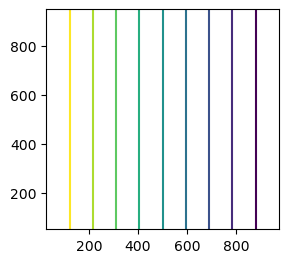

In [6]:
extent = (delr / 2.0, Lx - delr / 2.0, Ly - delc / 2.0, delc / 2.0)   ; fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect="equal")                         ; ax.contour(head[0, :, :], levels=np.arange(1, 10, 1), extent=extent)      

In [7]:
cbb = bf.CellBudgetFile(Path(workspace) / f"{name}.cbc")        ; kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text="FLOW RIGHT FACE", totim=times[-1])[0]  ; fff = cbb.get_data(text="FLOW FRONT FACE", totim=times[-1])[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge  ((frf, fff, None), mf, head)    # _____frf  _____ fff 

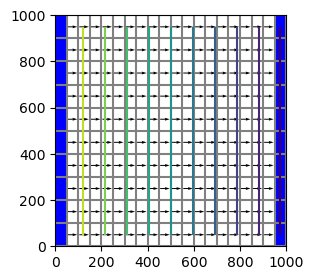

In [8]:
fig = plt.figure(figsize=(3, 3))  ; ax = fig.add_subplot(1, 1, 1, aspect="equal") 
modelmap = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)   ; quiver = modelmap.plot_vector(qx, qy)
qm = modelmap.plot_ibound() ; lc = modelmap.plot_grid()       ; cs = modelmap.contour_array(head, levels=np.linspace(0, 10, 11))    